In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm 
import numpy as np

print("CUDA:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA: False


In [4]:
def fibre_propagation(U0, wvl, x, z, refractive_index):
    nx = U0.shape[0]
    k = 2 * torch.pi / wvl

    dx = torch.abs(x[1] - x[0])
    fx = torch.fft.fftfreq(nx, dx, device=U0.device)

    U_out = torch.zeros(nx, z.shape[0], device=U0.device) + 0j
    U_out[:, 0] = U0 

    absorbing_window = torch.exp(-(x / (40e-6))**20)
    dz = z[1] - z[0]
    
    H = torch.exp(1j * k * dz * torch.sqrt(1 + 0j - (wvl * fx) ** 2))
    for i in range(1, z.shape[0]):
        U_in = U_out[:, i - 1]
        phase_shift = torch.exp(1j * k * dz * refractive_index[:, i - 1]) * absorbing_window
        U1 = torch.fft.fftshift(torch.fft.ifft(torch.fft.fft(torch.fft.ifftshift(U_out[:, i - 1] * phase_shift)) * H))
        U_out[:, i] = U1
        

    return U_out

Text(0, 0.5, 'x in mm')

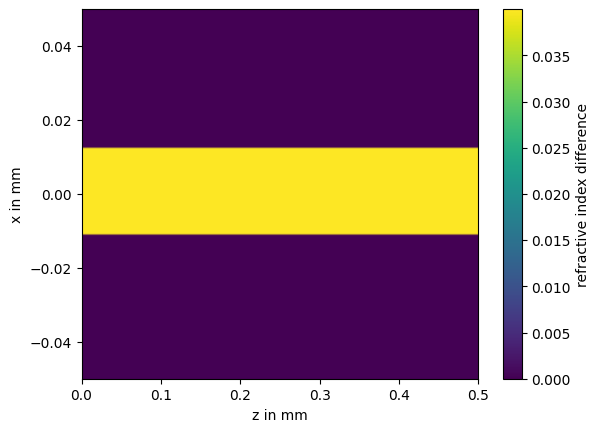

In [7]:
refractive_index = torch.zeros(128, 1000)
wvl = 633e-9

x = torch.linspace(-50e-6, 50e-6, 128)
z = torch.linspace(0e-6, 500e-6, 200)
refractive_index[50:80, :] = 0.04

# Plot with correct extent
plt.imshow(refractive_index.cpu().numpy(), 
           extent=[0, 500e-6 *1000, -50e-3, 50e-3],  # [left, right, bottom, top]
           aspect='auto',
           origin='lower')
plt.colorbar(label="refractive index difference")
plt.xlabel("z in mm")
plt.ylabel("x in mm")

Text(0, 0.5, 'x in mm')

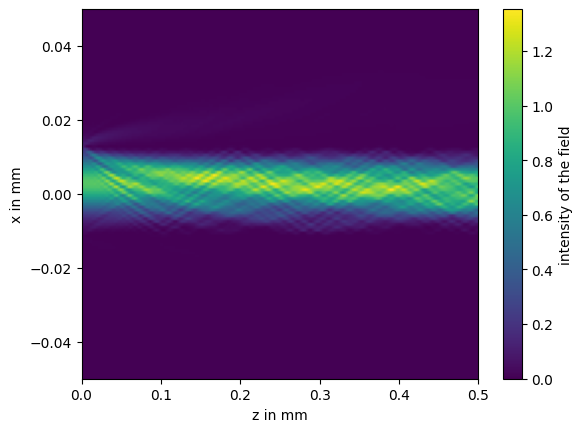

In [10]:
U0 = torch.exp(-(x-3e-6)**2 / (2 * 5e-6)**2)
U_prop = fibre_propagation(U0, wvl, x, z, refractive_index)

plt.imshow((torch.abs(U_prop)**2).cpu().numpy(),
           extent=[0, 500e-6 *1000, -50e-3, 50e-3],  # [left, right, bottom, top]
           aspect='auto',
           origin='lower')
plt.colorbar(label="intensity of the field")
plt.xlabel("z in mm")
plt.ylabel("x in mm")

# Focusing through Fiber

In this section, you will measure a transmission matrix. To do so, launch single 1D peaks into the fiber and record the output field at the end of the fibre. 

For the inversion of `M`, use `torch.pinverse(M, rcond=1e-2)`.

Determine a complex input field that, when launched through the fiber, produces a single peak at the x-location `x=5.12µm`.
The entire spatial domain is in 1D.

Verify that your calculated field focuses roughly to one spot by sending it through the fibre again.